$$Stock Price Prediction$$
We develop different models that can forecast stock prices of AAP based on various features and compare these models to get best prediction with minimum MSE using historical data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Selecting AAP data to do the time series prediction
Apple data for last 5 years

In [2]:
# Setting plot style
set_style("whitegrid")

# Loading the dataset
data_aap = pd.read_csv("data/individual_stocks_5yr/individual_stocks_5yr/AAP_data.csv", parse_dates=['date'])
data_aap.drop(columns=['open', 'high', 'low', 'Name', 'volume'], inplace=True)

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_aap_scaled = data_aap.copy()
data_aap_scaled['close'] = scaler.fit_transform(data_aap_scaled[['close']])

# Checking the data structure
print(data_aap.head())

        date  close
0 2013-02-08  78.90
1 2013-02-11  78.39
2 2013-02-12  78.60
3 2013-02-13  78.97
4 2013-02-14  78.84


In [3]:
#Normalized data structure
print(data_aap_scaled.head())

        date     close
0 2013-02-08  0.021900
1 2013-02-11  0.017794
2 2013-02-12  0.019485
3 2013-02-13  0.022464
4 2013-02-14  0.021417


In [4]:
# Split the data into train, validation, and test sets
train_size = int(len(data_aap_scaled) * 0.7)
val_size = int(len(data_aap_scaled) * 0.1)
test_size = len(data_aap_scaled) - train_size - val_size

data_aap_train = data_aap_scaled[:train_size].copy()
data_aap_val = data_aap_scaled[train_size:train_size + val_size].copy()
data_aap_test = data_aap_scaled[train_size + val_size:].copy()

In [5]:
# Sliding Window Linear Regression Model

W = 2 #Window Size
reg = LinearRegression()
data_aap_sw = data_aap_scaled[:train_size + val_size].copy()
for i in range(1, W):
    data_aap_sw[f'close_{i}'] = data_aap_sw['close'].shift(i)

data_aap_sw = data_aap_sw.transpose()    

predictions_sw = []
#Each prediction will be gotten from taking in the window of data points [i, i + W), performing a linear regression on this
#on this window giving a line f_i, and we adjoin f_i(i+W) 

for i in range(W-1):
    predictions_sw.append(0) #this gives a prediction of 0 for the first W-1 days

#This does the linear regression for each window and then appends the prediction    
for i in range(W-1, len(data_aap[:train_size + val_size]) ): 
    y_sw = data_aap_sw[i][1:] #Closing prices of each window 
    reg.fit(np.arange(i-(W-1),i+1).reshape(-1, 1) , y_sw)
    predictions_sw.append( reg.predict([[i+1]])[0]  )
    
# Calculate Validation MSE for Sliding Window Linear Regression
val_predictions_sw = predictions_sw[train_size:]
val_mse_sw = mean_squared_error(data_aap_val['close'], val_predictions_sw)

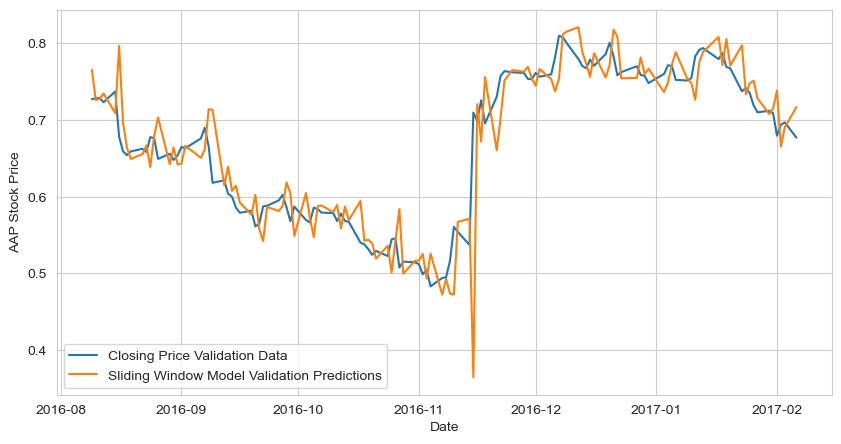

In [29]:
# Plot Sliding Window Linear Regression Results
plt.figure(figsize=(10, 5))

plt.plot(data_aap_val['date'], data_aap_val['close'], label='Closing Price Validation Data')
plt.plot(data_aap_val['date'], predictions_sw[train_size:], label='Sliding Window Model Validation Predictions')

plt.xlabel('Date')
plt.ylabel('AAP Stock Price')
plt.legend()
plt.show()

In [8]:
print('Sliding Window Linear Regression Validation MSE: {:.10f}'.format(val_mse_sw))

Sliding Window Linear Regression Validation MSE: 0.0019673769


In [9]:
###################################################################################################################

In [10]:
# LSTM Model
df = data_aap_scaled.drop(columns=['date']).dropna()
data = df.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Ensuring correct index for scaling the target
scaled_target = scaler.fit_transform(data[:, 0].reshape(-1, 1))

# Splitting the data into train, validation, and test sets
train, val, test = scaled_data[:train_size], scaled_data[train_size:train_size + val_size], scaled_data[train_size + val_size:]


In [11]:
# Creating sequences for LSTM
window_length = 15
trainX, trainY = [], []
for i in range(len(train) - window_length - 1):
    trainX.append(train[i:i + window_length])
    trainY.append(train[i + window_length, 0])  # Ensure correct index for target
trainX, trainY = np.array(trainX), np.array(trainY)

valX, valY = [], []
for i in range(len(val) - window_length - 1):
    valX.append(val[i:i + window_length])
    valY.append(val[i + window_length, 0])  # Ensure correct index for target
valX, valY = np.array(valX), np.array(valY)

testX, testY = [], []
for i in range(len(test) - window_length - 1):
    testX.append(test[i:i + window_length])
    testY.append(test[i + window_length, 0])  # Ensure correct index for target
testX, testY = np.array(testX), np.array(testY)

In [12]:

# Reshaping data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [13]:
# Building and training LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


C:\Users\chimp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


BEGINNING TRAINING

In [14]:
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data=(valX, valY))

Epoch 1/50
865/865 - 7s - 8ms/step - loss: 0.0078 - val_loss: 0.0240
Epoch 2/50
865/865 - 4s - 4ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 3/50
865/865 - 4s - 5ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 4/50
865/865 - 4s - 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
865/865 - 4s - 5ms/step - loss: 8.5462e-04 - val_loss: 9.9130e-04
Epoch 6/50
865/865 - 4s - 4ms/step - loss: 8.3255e-04 - val_loss: 0.0013
Epoch 7/50
865/865 - 4s - 5ms/step - loss: 6.9256e-04 - val_loss: 6.9645e-04
Epoch 8/50
865/865 - 5s - 6ms/step - loss: 7.1331e-04 - val_loss: 7.2744e-04
Epoch 9/50
865/865 - 4s - 4ms/step - loss: 6.6310e-04 - val_loss: 6.4342e-04
Epoch 10/50
865/865 - 6s - 7ms/step - loss: 5.5650e-04 - val_loss: 6.5173e-04
Epoch 11/50
865/865 - 4s - 5ms/step - loss: 5.5976e-04 - val_loss: 7.2948e-04
Epoch 12/50
865/865 - 4s - 4ms/step - loss: 5.2137e-04 - val_loss: 5.2940e-04
Epoch 13/50
865/865 - 4s - 5ms/step - loss: 5.7374e-04 - val_loss: 7.4834e-04
Epoch 14/50
865/865 - 4s - 5ms/

TRAINING COMPLETE

In [15]:

val_predictions = model.predict(valX)
val_predictions_inversed = scaler.inverse_transform(val_predictions.reshape(-1, 1))
valY_inversed = scaler.inverse_transform(valY.reshape(-1, 1))

val_mse_lstm = mean_squared_error(valY_inversed, val_predictions_inversed)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


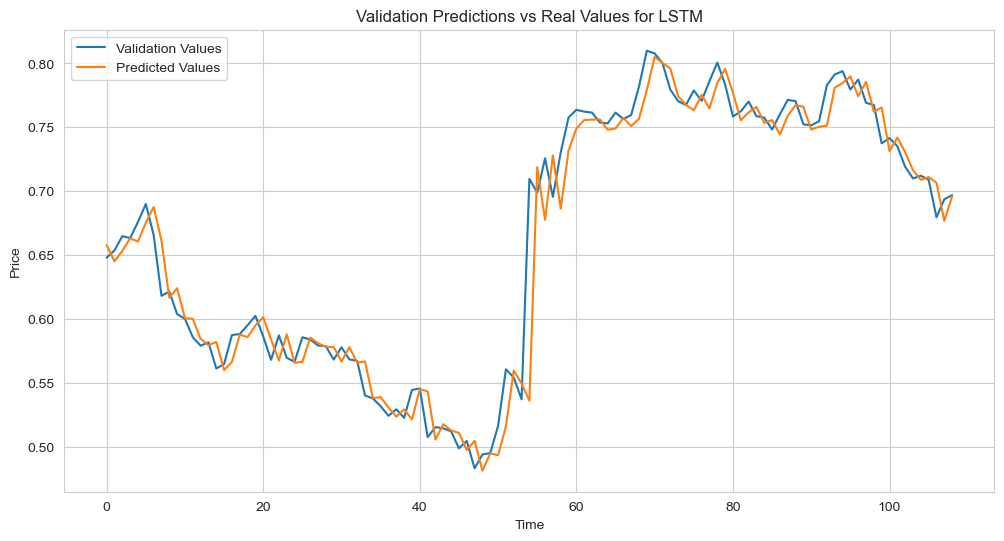

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(valY_inversed, label='Validation Values')
plt.plot(val_predictions_inversed, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Validation Predictions vs Real Values for LSTM')
plt.legend()
plt.show()

In [17]:
print('LSTM Validation MSE: {:.10f}'.format(val_mse_lstm))

LSTM Validation MSE: 0.0005344869


In [18]:

# Naive Baseline Model
naive_predictions_val = data_aap_val['close'].shift(1).dropna()
naive_mse_val = mean_squared_error(data_aap_val['close'][1:], naive_predictions_val)

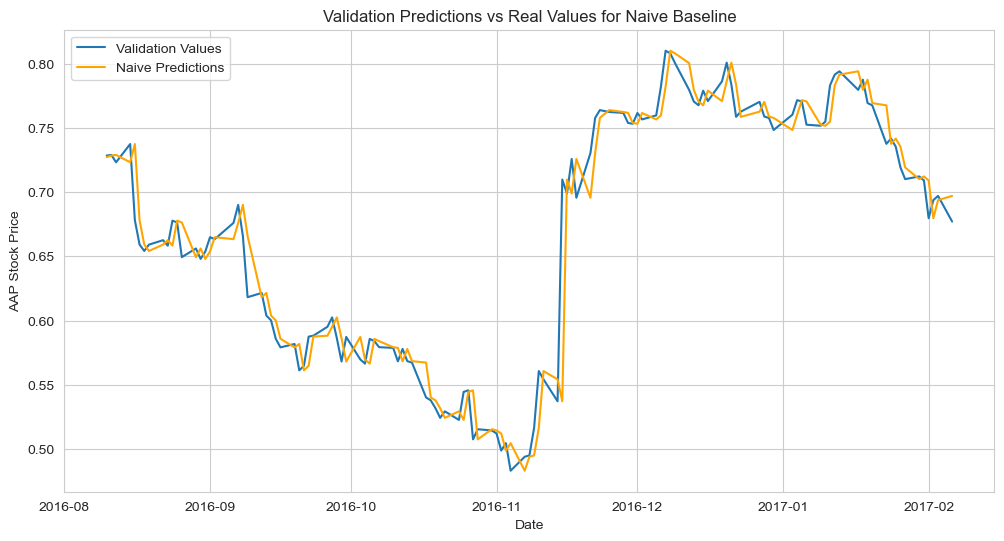

In [19]:

# Plotting Naive Baseline Model Results
plt.figure(figsize=(12, 6))
plt.plot(data_aap_val['date'][1:], data_aap_val['close'][1:], label='Validation Values')
plt.plot(data_aap_val['date'][1:], naive_predictions_val, label='Naive Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('AAP Stock Price')
plt.title('Validation Predictions vs Real Values for Naive Baseline')
plt.legend()
plt.show()

In [20]:
print('Naive Baseline Validation MSE: {:.10f}'.format(naive_mse_val))

Naive Baseline Validation MSE: 0.0004928494


In [21]:

# Printing the best model based on validation MSE
min_mse = min(val_mse_sw, val_mse_lstm, naive_mse_val)

if min_mse == val_mse_sw:
    print('The Sliding Window Linear Regression Model is better with a Validation MSE of {:.10f}'.format(val_mse_sw))
elif min_mse == val_mse_lstm:
    print('The LSTM Model is better with a Validation MSE of {:.10f}'.format(val_mse_lstm))
else:
    print('The Naive Baseline Model is better with a Validation MSE of {:.10f}'.format(naive_mse_val))


The Naive Baseline Model is better with a Validation MSE of 0.0004928494


By varying the window size we can enhance the MSE. But in all the cases Naive Baseline is performing better.